# Computer Vision

## Assignment - Gaussian Mixture Model (GMM)

In [140]:
%pip install comet_ml --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Comet Config

In [141]:
from comet_ml import Experiment

experiment = Experiment(project_name = "cv-gmm")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mamello-justice/cv-gmm/4b45a94120324ab49c439a19569082e3
COMET INFO:   Parameters:
COMET INFO:     batch_size : 2
COMET INFO:     epochs     : 2
COMET INFO:     features   : ['red', 'green', 'blue', 'DoG']
COMET INFO:     input_size : [768, 1024]
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (195.59 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to en

### Imports

In [142]:
from glob import glob
import time
from os import path

from natsort import natsorted
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import imageio
import cv2
import numpy as np
import scipy
from skimage import img_as_float32
from scipy.stats import multivariate_normal


print(f"numpy=={np.__version__}")
print(f"scipy=={scipy.__version__}")

numpy==1.23.4
scipy==1.9.3


### Common

In [143]:
def load_images(input_dir, height, width):
    image_dir = path.join(input_dir, f'images-{width}x{height}')
    image_paths = natsorted(glob(f'{image_dir}/*.png'))
    raw_images = np.array([
        img_as_float32(imageio.imread(path))
        for path in tqdm(image_paths, 'Reading in images')
    ])

    mask_dir = path.join(input_dir, f'masks-{width}x{height}')
    mask_paths = natsorted(glob(f'{mask_dir}/*.png'))
    raw_masks = np.array([
        img_as_float32(imageio.imread(path))
        for path in tqdm(mask_paths, 'Reading in masks')
    ])

    return raw_images, raw_masks

In [144]:
def split_data(raw_images, raw_masks):
    N = len(raw_images)
    indices = np.random.permutation(N)

    train_end = int(0.7*N) + 1
    train_indices = indices[:train_end]

    validation_end = train_end + int(0.15*N)
    validation_indices = indices[train_end:validation_end]

    test_indices = indices[validation_end:]

    return (raw_images[train_indices], raw_masks[train_indices]),\
        (raw_images[validation_indices], raw_masks[validation_indices]),\
        (raw_images[test_indices], raw_masks[test_indices])

In [145]:
def preprocess_images(raw_images, raw_masks, features):
    images = np.empty((*raw_images.shape[:-1], 0))
    masks = raw_masks
    
    if len(masks.shape) == 3:
        masks = np.expand_dims(masks, axis=3)
        
    if 'rgb' in features:
        images = np.append(images, raw_images, axis=3)
          
    if 'DoG' in features:
        sigma = 1
        K=3
        kernel_shape = (49,49)
        
        temp = []
        
        for i in range(len(images)):
            G1 = cv2.GaussianBlur(images[i], ksize=kernel_shape, sigmaX=sigma)
            G2 = cv2.GaussianBlur(images[i], ksize=kernel_shape, sigmaX=K**2 * sigma)
            temp.append(G2 - G1)

        images = np.append(images, temp, axis=3)
        
    return images, masks

### GMM Class

In [177]:
class GMM:
    def __init__(self, K: int, I: int):
        """Initialize Gaussian mixture model

        Args:
            K (int): Number of gaussian models
            I (int): Number of features
        """
        self.K = K
        self.I = I
        
        self.compiled = False
        
    def compile(self):
        self.lambda_m = np.ones(self.K) / self.K
        
        self.mu_m = np.random.random((self.K, self.I))
        
        sigma_m = np.random.random((self.K, self.I, self.I))
        for k in range(self.K):
                sigma_m[k] *= sigma_m[k].T
                sigma_m[k] += self.I * np.eye(self.I)
        self.sigma_m = sigma_m
        
        self.compiled = True
        
    def _require_compile(self):
        if not self.compiled:
            raise Exception("Cannot fit before compiling model. Run model.compile()")
        
    def __call__(self, x):
        self._require_compile()
        
        values = np.empty((0, *x.shape[:-1]))
        
        for k in range(self.K):
            y = [self.lambda_m[k] * multivariate_normal.pdf(x, self.mu_m[k], self.sigma_m[k])]
            values = np.append(values, y, axis=0)
        
        return np.sum(values, axis=0), values
    
    def _expectation_step(self, x):
        pass
            
    
    def _maximisation_step(self, x):
        pass
        
    def _train_step(self):
        pass
        
    def fit(self, x, y, batch_size=1, epochs=1, validation_data=None):
        self._require_compile()
        pass
    
    def save(self, path):
        pass
    
    @staticmethod
    def load_model(path):
        pass


### Constants

In [147]:
BACKBONE = 'vgg16'

assets_dir = './assets'
data_dir = './data'

default_input_size = [768, 1024]
default_input_dir = path.join(
    assets_dir,
    f'puzzle_corners_{default_input_size[1]}x{default_input_size[0]}')

time_now = int(time.time())

default_cp_path = path.join(data_dir, str(time_now), 'cp.ckpt')
default_model_path = path.join(data_dir, str(time_now), 'model.h5')

### Params

In [148]:
params = {
    'batch_size': 2,
    'epochs': 2,
    'features': ['rgb', 'DoG'],
    'input_size': default_input_size,
}

experiment.log_parameters(params)

### Setup

In [149]:
def setup_args():
    return {
        'cp_path': default_cp_path,
        'input_dir': default_input_dir,
        'model_path': default_model_path,
        'update_model': None,
        'cpu': True
    }

### Train

In [150]:
args = setup_args()

batch_size = params['batch_size']
epochs = params['epochs']
features = params['features']
input_size = params['input_size']

input_dir = args['input_dir']
model_path = args['model_path']
update_model = args['update_model']

height, width = input_size

raw_images, raw_masks = load_images(input_dir, height, width)
images, masks = preprocess_images(raw_images, raw_masks, features)

Reading in images:   0%|          | 0/48 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28248\1150969664.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_as_float32(imageio.imread(path))
Reading in masks:   0%|          | 0/48 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28248\1150969664.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_as_float32(imageio.imread(path))
Reading in masks: 100%|██████████| 48/48 [00:00<00:00, 307.63it/s]


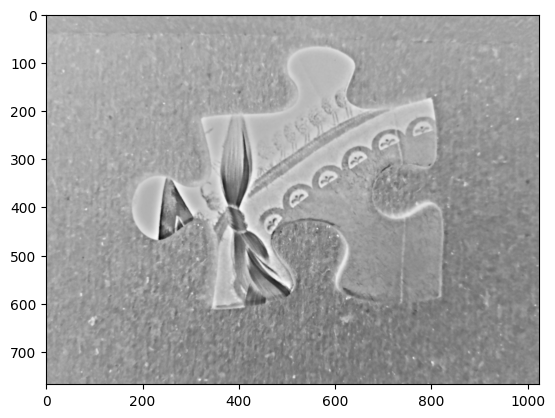

In [178]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) =\
    split_data(images, masks)

if update_model and model_path:
    model = GMM.load_model(model_path)
else:
    model = GMM(K=2, I=images.shape[-1])
    
assert model is not None, "Could not load model"

model.compile()

model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_x, val_y))

output, _ = model(train_x[:2])
plt.imshow(output[0], cmap="gray")

model.save(model_path)

### Comet Commit

In [152]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mamello-justice/cv-gmm/d3a0de7a21214827857d097fc662f04c
COMET INFO:   Parameters:
COMET INFO:     batch_size : 2
COMET INFO:     epochs     : 2
COMET INFO:     features   : ['rgb', 'DoG']
COMET INFO:     input_size : [768, 1024]
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (198.78 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seco